# Notebook for subtask-A of phase one

## Fitting a model to each individual station

Here we construct an ensemble, with the use case of predicting for new stations

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

# Define some functions

- replace_nan fills NaN values with column means. We don't use it but it was useful for exploratory analysis
- show_nans is also for exploration
- convert_weekdays moves weekday strings into integers from one to seven
- score_abs_error takes a model with SKLEARN syntax and used it to predict the number of bikes based on input data, then return the mean absolute error. round_ specifies whether output should be rounded to integers.
- reasonable_predictions is a bit redundant, taking a model and data and predicting


In [2]:
def replace_nan(df):
    # get a list of all the columns containing NaN
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    # compute and fill each NaN with the columns mean
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    print(np.unique(df['station']))
    print(df.shape[0] - df.dropna().shape[0])
#     print(df[df.columns[df.isnull().any()]].columns)
    print(df.isnull().any())
    print()
    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()))# * num_docks  )
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy())# * num_docks
    y_gold = data["bikes"].to_numpy()# * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    y_pred = np.around(y_pred)
    return y_pred


The next cell has functions to remove unwanted features, add our new isOff feature. 

It reads all the training files and builds collections of training sets, validation sets, and scalers for each station.

In [3]:
pd.options.mode.chained_assignment = None

def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    if row['hour'] > 17 or row['hour'] < 9:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    del dataframe["month"]
    del dataframe["year"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    del dataframe['isHoliday']
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def prepare_dataframe(dataframe):
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)

    default_columns = ["isOff"] + default_columns
    default_columns.remove('weekday')
    
    
    dataframe = dataframe[default_columns]

    del dataframe['isHoliday']
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]

    num_docks = dataframe["numDocks"]
    
    dataframe["numDocks"]

    return dataframe, num_docks


trains = []
vals = []

train_docks_list = []
val_docks_list = []

scalers = []
count = 0
for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    count += 1

val_inds = np.random.randint(0, count - 1, 2)
print(f'Stations kept as holdout: {200 + val_inds}')
val_inds = list(val_inds)


for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    tmp = pd.read_csv(path)

    tmp = tmp.dropna(axis='rows')


    
    if i  not in  val_inds:
        train, val = train_test_split(tmp, test_size=0.02)

        train, train_docks = prepare_dataframe(train)
        val, val_docks = prepare_dataframe(val)

        scaler = RobustScaler()
        
        train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
        val[val.columns[:-1]] = scaler.transform(val[val.columns[:-1]])

        trains.append(train)
        vals.append(val)

        train_docks_list.append(train_docks)
        val_docks_list.append(val_docks)

        scalers.append(scaler)
        
        del tmp
    elif i == val_inds[0]:
        val_set = tmp.copy()


        val_set, val_set_docks = prepare_dataframe(val_set)
    else:
        print('found val set two')
        val_set_two = tmp.copy()


        val_set_two, val_set_docks_two = prepare_dataframe(val_set_two)


Stations kept as holdout: [255 229]
found val set two


## Fit a model for each station on its training set

In [4]:
from time import time
from tqdm import tqdm
start = time()
print("initialised")

models = []

for i in tqdm(range(len(trains))):
    #forest_boost = AdaBoostRegressor(n_estimators=400, random_state=0, learning_rate = 0.5)
    forest_boost = RandomForestRegressor(n_estimators= 200, max_depth= 9)
    #forest_boost = GradientBoostingRegressor(n_estimators= 150, max_depth= 3, learning_rate= 0.1, loss="squared_error")#
    forest_boost.fit(trains[i].iloc[:,:-1].to_numpy(), trains[i]["bikes"].to_numpy())
    
    models.append(forest_boost)
print(f'fitted in {time() - start}s')

initialised


100%|████████████████████████████████████████████| 73/73 [00:24<00:00,  2.98it/s]

fitted in 24.534467935562134s


In [5]:
import matplotlib.pyplot as plt

errors = []
rounded_errors = []
y_pred = []
y_gold = []

for i in tqdm(range(len(vals))):
    errors.append(score_abs_error(models[i], vals[i], val_docks_list[i]))
    rounded_errors.append(score_abs_error(models[i], vals[i], val_docks_list[i], round_ = True))
    
    pred = list(models[i].predict(vals[i].iloc[:, :-1].to_numpy()))# * val_docks_list[i])
    
    y_pred = y_pred + pred
    
    y_gold = y_gold + list(vals[i]["bikes"])# * val_docks_list[i])
    
print(f'Non-rounded ensemble error: {np.mean(errors)}')
print(f'Rounded ensemble error: {np.mean(rounded_errors)}')

100%|████████████████████████████████████████████| 73/73 [00:01<00:00, 67.67it/s]

Non-rounded ensemble error: 1.895581889817394
Rounded ensemble error: 1.8630136986301373


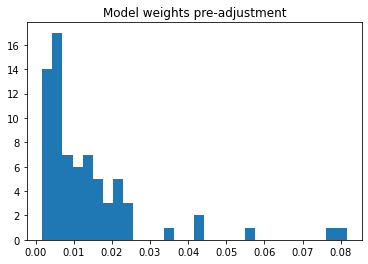

In [6]:
model_weights = np.array(errors)
model_weights = 1/ model_weights**(2)
model_weights = model_weights / np.sum(model_weights)


plt.hist(model_weights, bins=30)
plt.title("Model weights pre-adjustment")
plt.show()

## Measure performance on the first holdout station and adjust weights accordingly

In [7]:
def ensemble_validation_errors(models, scalers, x, y,  docks):
    results = np.zeros(len(models))
    
    for i, m in enumerate(models):

        x_i = scalers[i].transform(x)
        
        results[i] = mean_absolute_error(m.predict(x_i),y)# * docks, y*docks)

    return results


validation_errors = ensemble_validation_errors(models, scalers, val_set.iloc[:, :-1], val_set["bikes"], val_set_docks)

print(f'Validation error pre re-tuning:  {np.mean(validation_errors)}')

model_weights = model_weights / validation_errors**2
model_weights = model_weights / np.sum(model_weights)


Validation error pre re-tuning:  3.5971568922578627


## Measure performance on second holdout station

In [8]:
def ensemble_predict(models, scalers, model_weights, x):
    results = np.zeros(x.shape[0])

    for i, m in enumerate(models):

        x_i = scalers[i].transform(x)
        
        results = results + m.predict(x_i) * model_weights[i]

    return results

y_pred = ensemble_predict(models, scalers, model_weights, val_set_two.iloc[:,:-1])

val_gold_two = val_set_two["bikes"].to_numpy()

print(f'\nError on second holdout station: {mean_absolute_error(val_gold_two, y_pred)}')


Error on second holdout station: 2.177834013880668


## Use ensemble to predict on test data

In [9]:
test = pd.read_csv('test.csv')

ids = test["Id"]

del test["Id"]

test, test_docks = prepare_dataframe(test)

y_pred = np.around(ensemble_predict(models, scalers, model_weights, test)).astype(np.int32)


sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

sub_df.to_csv("submission.csv")